# Instacart Exploratory Data Analysis
Instacart data is described as such on their blog post at https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2. "This anonymized dataset contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.
For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders."

In this notebook I'll attempt to explore the dataset, and recreate a few of the visualizations they have included in the blog post.

I've imported the tables into SQLite separately from this notebook for practice with SQL, using csvtosqlite.py. GUI importing was suboptimal as it's not obvious how to set column type appropriately. Data would import as all text, which is annoying and inefficient.

## Connect to SQLite database

In [1]:
import sqlite3
conn = sqlite3.connect('instacart2.sqlite')
c = conn.cursor()

Some database probing to make sure things look good

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
# c.execute('''SELECT * FROM departments LIMIT 10''')
# pd.read_sql('''SELECT * FROM departments LIMIT 10''',conn)
pd.read_sql('''
SELECT opp.reordered, p.product_name, a.aisle
FROM order_products__prior AS opp LEFT JOIN 
(products AS p LEFT JOIN aisles AS a ON p.aisle_id=a.aisle_id) 
ON opp.product_id=p.product_id
WHERE opp.reordered==1
LIMIT 10''',conn)

,reordered,product_name,aisle
0,1,Organic Egg Whites,eggs
1,1,Michigan Organic Kale,fresh vegetables
2,1,Coconut Butter,oils vinegars
3,1,Carrots,fresh vegetables
4,1,Original Unflavored Gelatine Mix,doughs gelatins bake mixes
5,1,All Natural No Stir Creamy Almond Butter,spreads
6,1,Total 2% with Strawberry Lowfat Greek Strained...,yogurt
7,1,Unsweetened Almondmilk,soy lactosefree
8,1,Lemons,packaged vegetables fruits
9,1,Organic Baby Spinach,packaged vegetables fruits


see how much of the orders are prior, test, and train. The prior set is for training, train set for validation, and the test set is for submission to kaggle. 

In [14]:
pd.read_sql('''
SELECT count(order_id), eval_set
FROM orders
GROUP BY eval_set
''',conn)

,count(order_id),eval_set
0,3214874,prior
1,75000,test
2,131209,train


## Recreate blog table of user 1's first two orders

In [4]:
pd.read_sql('''
SELECT op.user_id AS id, op.order_id AS order_id, op.order_number AS order_no, op.order_dow AS dow, 
op.order_hour_of_day AS hod, op.add_to_cart_order As add_order, op.product_id AS p_id, p.product_name AS product_name
FROM (
    SELECT o.user_id, o.order_id, o.order_number, o.order_dow, 
    o.order_hour_of_day,opp.add_to_cart_order, opp.product_id
    FROM orders AS o LEFT JOIN order_products__prior AS opp ON o.order_id=opp.order_id
    WHERE user_id == 1 AND order_number IN(1,2)) AS op
LEFT JOIN products AS p ON op.product_id=p.product_id
ORDER BY op.order_number ASC, op.add_to_cart_order ASC;
''',conn)

,id,order_id,order_no,dow,hod,add_order,p_id,product_name
0,1,2539329,1,2,8,1,196,Soda
1,1,2539329,1,2,8,2,14084,Organic Unsweetened Vanilla Almond Milk
2,1,2539329,1,2,8,3,12427,Original Beef Jerky
3,1,2539329,1,2,8,4,26088,Aged White Cheddar Popcorn
4,1,2539329,1,2,8,5,26405,XL Pick-A-Size Paper Towel Rolls
5,1,2398795,2,3,7,1,196,Soda
6,1,2398795,2,3,7,2,10258,Pistachios
7,1,2398795,2,3,7,3,12427,Original Beef Jerky
8,1,2398795,2,3,7,4,13176,Bag of Organic Bananas
9,1,2398795,2,3,7,5,26088,Aged White Cheddar Popcorn


## Create plot showing percent reorder vs number of purchase for each aisle colored by department

In [76]:
#first get the correct data
reorderaisle=pd.read_sql('''
SELECT d.department, a.aisle, op.num_purch, (op.num_purch*1.0)/(op.count_purch) AS percent_purch 
FROM ((
SELECT sum(opp.reordered) AS num_purch, count(opp.reordered) AS count_purch, p.product_id, p.aisle_id, p.department_id
FROM order_products__prior AS opp LEFT JOIN products AS p ON opp.product_id=p.product_id
GROUP BY p.aisle_id)AS op LEFT JOIN aisles AS a ON a.aisle_id=op.aisle_id)
LEFT JOIN departments AS d ON d.department_id=op.department_id
GROUP BY a.aisle


''',conn)

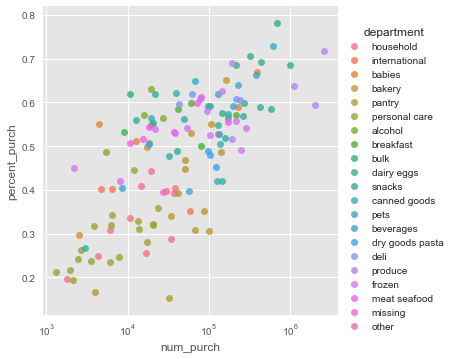

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

aisleplot=sns.lmplot('num_purch','percent_purch',data=reorderaisle,hue='department', fit_reg=False)
aisleplot.set(xscale='log')

reorderaisle.to_csv('reorderaisle.csv')


Note that perishables tend to be both purchased and repurchased more than non-perishables.

## Recreate time of day graph

In [132]:
#First get correct data
todorder=pd.read_sql('''
SELECT p.product_name,op.order_hour_of_day, op.COUNT
FROM (
    SELECT opp.product_id, o.order_id, o.order_hour_of_day, count(o.order_id) AS COUNT
    FROM orders AS o LEFT JOIN order_products__prior AS opp ON o.order_id=opp.order_id
    GROUP BY o.order_hour_of_day, opp.product_id) AS op 
LEFT JOIN products AS p ON op.product_id=p.product_id
GROUP BY p.product_name, op.order_hour_of_day
ORDER BY op.order_hour_of_day

''',conn)

In [134]:
todorder
todorder.to_csv('todorder.csv')

In [135]:
#First get correct data
pd.read_sql('''
SELECT product_id, product_name
FROM products
WHERE product_name LIKE 'Banana'
''',conn)

,product_id,product_name
0,24852,Banana
